Version 1: Exécuter sur plusieurs graphes de même taille (40 sommets) en graphe complet

[[ 0.         25.26388396 73.16094089 ... 72.27177034 29.2295428
  73.96620078]
 [25.26388396  0.         40.55436056 ... 36.54539681 48.21820855
  27.89651194]
 [73.16094089 40.55436056  0.         ... 18.40243944 33.13515037
  46.71470958]
 ...
 [72.27177034 36.54539681 18.40243944 ...  0.         62.81432171
  34.90771044]
 [29.2295428  48.21820855 33.13515037 ... 62.81432171  0.
  51.21150722]
 [73.96620078 27.89651194 46.71470958 ... 34.90771044 51.21150722
   0.        ]]
[[ 0.         45.50313707 33.1474066  ... 68.95436779 34.82538166
  50.8069809 ]
 [45.50313707  0.         46.24744784 ... 23.41513907 52.08608284
  62.16303816]
 [33.1474066  46.24744784  0.         ... 18.94586939 24.79317633
  42.75459619]
 ...
 [68.95436779 23.41513907 18.94586939 ...  0.         40.75370311
  53.31863909]
 [34.82538166 52.08608284 24.79317633 ... 40.75370311  0.
  72.62267607]
 [50.8069809  62.16303816 42.75459619 ... 53.31863909 72.62267607
   0.        ]]
[[ 0.         32.46612362 73.0886

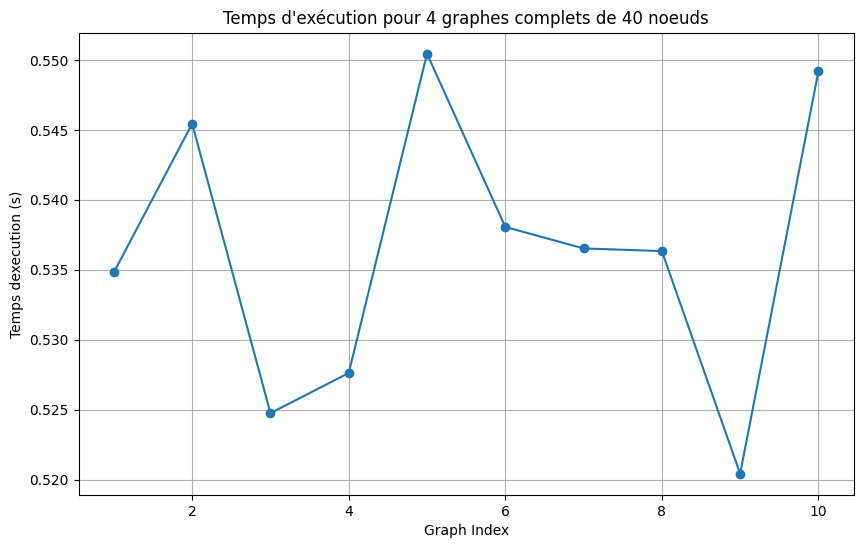

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import os

def create_graph(cities_count, complete=True, threshold=0.5):
    mat = np.random.random((cities_count, cities_count))
    mat = mat + mat.T
    np.fill_diagonal(mat, 0)
    adj_matrix = mat * cities_count
    if not complete:
        adj_matrix[adj_matrix < threshold] = 0
    print(adj_matrix)
    G = nx.from_numpy_array(adj_matrix)
    if not nx.is_connected(G):
        raise ValueError("Le graphe généré n'est pas connecté. Essayez de régénérer la matrice.")
    return G, adj_matrix

def run_aco_on_graph(G, adj_matrix, n_ants, n_best, n_iterations, decay, alpha, beta):
    pheromone = np.ones(adj_matrix.shape) / len(adj_matrix)
    all_time_shortest_path = ("placeholder", np.inf)
    for i in range(n_iterations):
        all_paths = gen_all_paths(n_ants, pheromone, adj_matrix, alpha, beta)
        spread_pheromone(all_paths, pheromone, n_best, decay)
        shortest_path = min(all_paths, key=lambda x: x[1])
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path
    return all_time_shortest_path[1]

def gen_path(start, pheromone, distances, alpha, beta):
    path = []
    visited = set()
    visited.add(start)
    prev = start
    for _ in range(len(distances) - 1):
        move = pick_move(pheromone[prev, :], distances[prev, :], visited, alpha, beta)
        path.append((prev, move))
        prev = move
        visited.add(move)
    path.append((prev, start))
    return path

def pick_move(pheromone_row, dist_row, visited, alpha, beta):
    pheromone_row = np.copy(pheromone_row)
    pheromone_row[list(visited)] = 0
    dist_row[dist_row == 0] = np.inf
    with np.errstate(divide='ignore'):
        row = pheromone_row ** alpha * ((1.0 / dist_row) ** beta)
    row = np.nan_to_num(row)
    norm_row = row / row.sum()
    move = np.random.choice(range(len(pheromone_row)), 1, p=norm_row)[0]
    return move

def gen_all_paths(n_ants, pheromone, distances, alpha, beta):
    all_paths = []
    for i in range(n_ants):
        path = gen_path(0, pheromone, distances, alpha, beta)
        all_paths.append((path, calc_path_length(path, distances)))
    return all_paths

def calc_path_length(path, distances):
    total_dist = 0
    for (i, j) in path:
        total_dist += distances[i, j]
    return total_dist

def spread_pheromone(all_paths, pheromone, n_best, decay):
    sorted_paths = sorted(all_paths, key=lambda x: x[1])
    for path, dist in sorted_paths[:n_best]:
        for move in path:
            pheromone[move] += 1.0 / dist
    pheromone *= decay

n_ants = 10
n_best = 5
n_iterations = 50
decay = 0.5
alpha = 1
beta = 2

cities_count = 40
execution_times_complete = []
nb_graphs = 10

for i in range(nb_graphs):  
    G, adj_matrix = create_graph(cities_count, complete=True)
    start_time = time.time()
    run_aco_on_graph(G, adj_matrix, n_ants, n_best, n_iterations, decay, alpha, beta)
    exec_time = time.time() - start_time
    execution_times_complete.append(exec_time)

plt.figure(figsize=(10, 6))
plt.plot(range(1, nb_graphs+1), execution_times_complete, marker='o')
plt.xlabel('Graph Index')
plt.ylabel('Temps dexecution (s)')
plt.title('Temps d\'exécution pour 4 graphes complets de 40 noeuds')
plt.grid(True)
plt.show()

np.savetxt('execution_times_complete_40_nodes.csv', execution_times_complete, delimiter=',')



Version 2: Exécuter sur plusieurs graphes de même taille (40 sommets) en graphe non complet

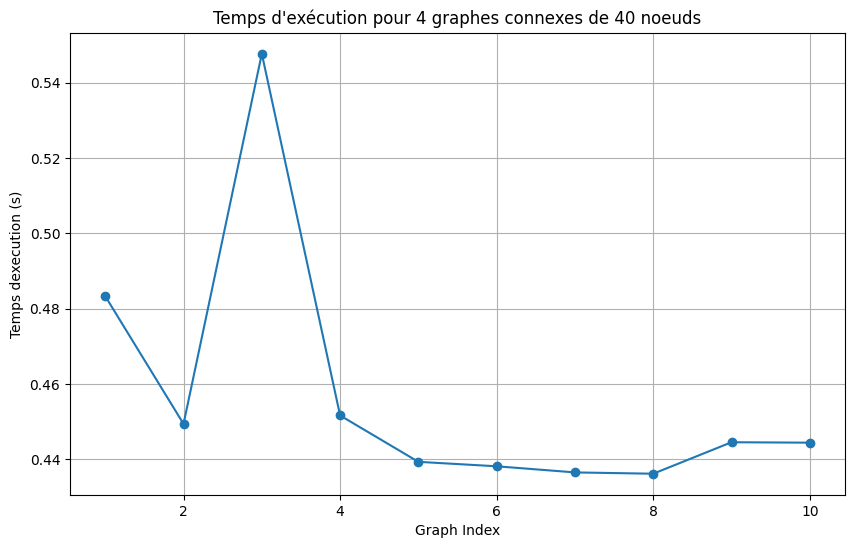

In [18]:
n_ants = 10
n_best = 5
n_iterations = 50
decay = 0.5
alpha = 1
beta = 2

cities_count = 40
execution_times_non_complete = []

nb_graphs = 10

for i in range(nb_graphs): 
    G, adj_matrix = create_graph(cities_count, complete=False, threshold=0.2)
    start_time = time.time()
    run_aco_on_graph(G, adj_matrix, n_ants, n_best, n_iterations, decay, alpha, beta)
    exec_time = time.time() - start_time
    execution_times_non_complete.append(exec_time)

plt.figure(figsize=(10, 6))
plt.plot(range(1, nb_graphs+1), execution_times_non_complete, marker='o')
plt.xlabel('Graph Index')
plt.ylabel('Temps dexecution (s)')
plt.title('Temps d\'exécution pour 4 graphes connexes de 40 noeuds')
plt.grid(True)
plt.show()

np.savetxt('execution_times_non_complete_40_nodes.csv', execution_times_non_complete, delimiter=',')



Version 3: Faire évoluer le nombre de sommets pour un graphe complet

[[ 0.          6.98302549  5.39783329 12.27483208  8.00519601 10.46619441
  13.04123622  2.9523618  11.20141763  7.78958332]
 [ 6.98302549  0.          0.95306916  2.97994184 10.96414217 16.72769925
   3.03768444 15.62831414  4.37134754 12.30414979]
 [ 5.39783329  0.95306916  0.         12.03182724 15.02508928  9.05725608
  10.11218948 13.96536366 16.36869547  6.48863094]
 [12.27483208  2.97994184 12.03182724  0.         14.36325113 13.32830216
  16.70285511  8.29241058 11.8820311  13.58950047]
 [ 8.00519601 10.96414217 15.02508928 14.36325113  0.         11.53592208
   4.48818764 11.30223441  4.92376314 10.40928386]
 [10.46619441 16.72769925  9.05725608 13.32830216 11.53592208  0.
   3.35370613 10.90252465 14.40071415  6.22532109]
 [13.04123622  3.03768444 10.11218948 16.70285511  4.48818764  3.35370613
   0.          7.18804182  8.67356796 14.83538811]
 [ 2.9523618  15.62831414 13.96536366  8.29241058 11.30223441 10.90252465
   7.18804182  0.          7.51044148 16.72918509]
 [11.201

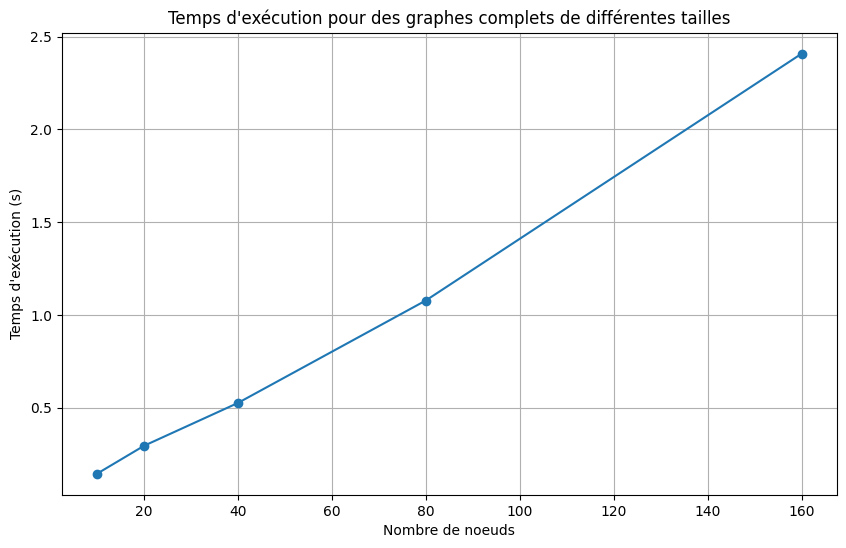

In [16]:
cities_counts = [10,20,40,80,160]
execution_times_varying_complete = []

for cities_count in cities_counts:
    G, adj_matrix = create_graph(cities_count, complete=True)
    start_time = time.time()
    run_aco_on_graph(G, adj_matrix, n_ants, n_best, n_iterations, decay, alpha, beta)
    exec_time = time.time() - start_time
    execution_times_varying_complete.append(exec_time)

plt.figure(figsize=(10, 6))
plt.plot(cities_counts, execution_times_varying_complete, marker='o')
plt.xlabel('Nombre de noeuds')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution pour des graphes complets de différentes tailles')
plt.grid(True)
plt.show()

np.savetxt('execution_times_varying_complete.csv', execution_times_varying_complete, delimiter=',')



Version 4: Faire évoluer le nombre de sommets pour un graphe non complet

[[ 0.          7.37656466 12.8104081   5.64633841  4.24167322 16.75540767
   9.36089948 13.45785016 10.21748014  8.49667433]
 [ 7.37656466  0.          6.5594101   6.07833518  5.06716919  5.21334092
   8.25086264  5.18926396  8.25464825 14.28866204]
 [12.8104081   6.5594101   0.          9.79476469 12.47144204  5.90141588
   4.90347328 16.74186371  8.0569604  13.02155113]
 [ 5.64633841  6.07833518  9.79476469  0.         14.75054629  9.80881395
  10.32365647 14.74539199  9.94375172  7.28765633]
 [ 4.24167322  5.06716919 12.47144204 14.75054629  0.         15.83797736
  18.62817355 11.93444299 10.16813326 11.20857003]
 [16.75540767  5.21334092  5.90141588  9.80881395 15.83797736  0.
  10.29537176  4.59965224  7.19822336 13.13092487]
 [ 9.36089948  8.25086264  4.90347328 10.32365647 18.62817355 10.29537176
   0.         13.98209821 10.86309652  5.5784687 ]
 [13.45785016  5.18926396 16.74186371 14.74539199 11.93444299  4.59965224
  13.98209821  0.         10.05933222  1.56089452]
 [10.217

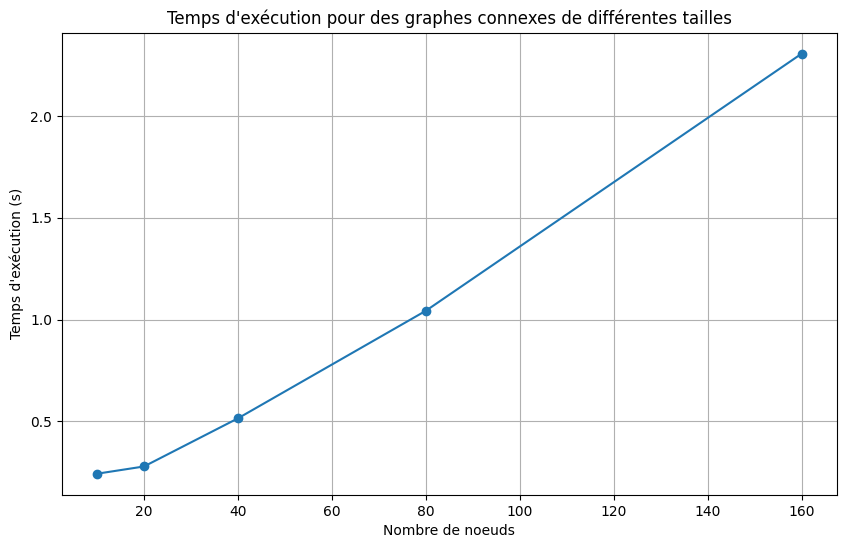

In [15]:
execution_times_varying_non_complete = []

for cities_count in cities_counts:
    G, adj_matrix = create_graph(cities_count, complete=False, threshold=0.5)
    start_time = time.time()
    run_aco_on_graph(G, adj_matrix, n_ants, n_best, n_iterations, decay, alpha, beta)
    exec_time = time.time() - start_time
    execution_times_varying_non_complete.append(exec_time)

# Plot the execution times
plt.figure(figsize=(10, 6))
plt.plot(cities_counts, execution_times_varying_non_complete, marker='o')
plt.xlabel('Nombre de noeuds')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution pour des graphes connexes de différentes tailles')
plt.grid(True)
plt.show()

# Save the execution times
np.savetxt('execution_times_varying_non_complete.csv', execution_times_varying_non_complete, delimiter=',')



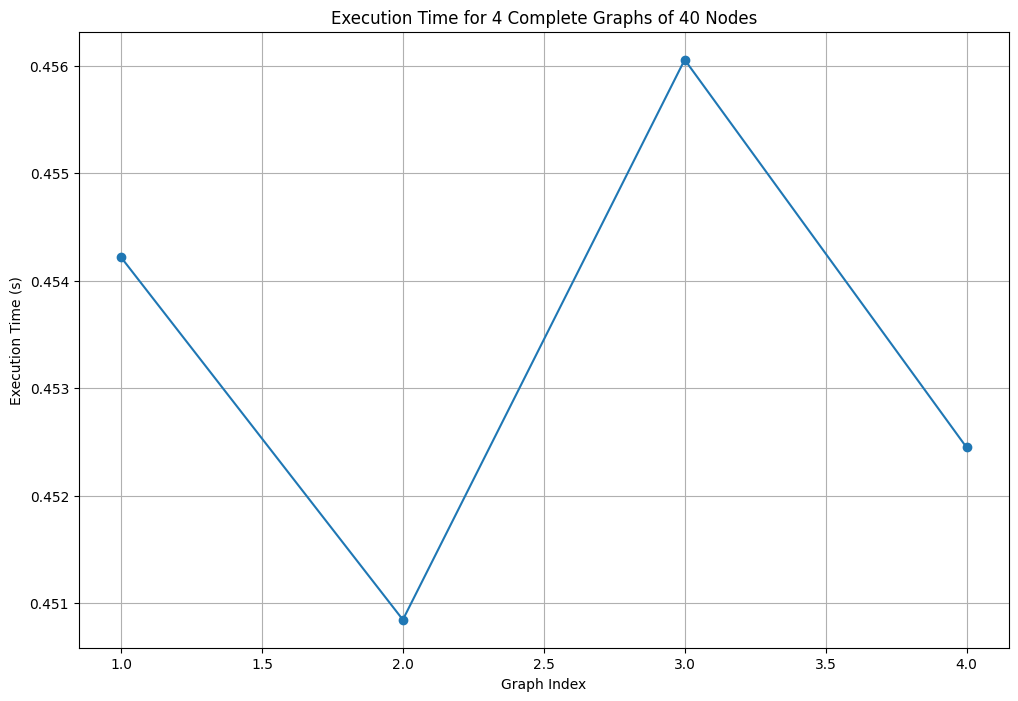

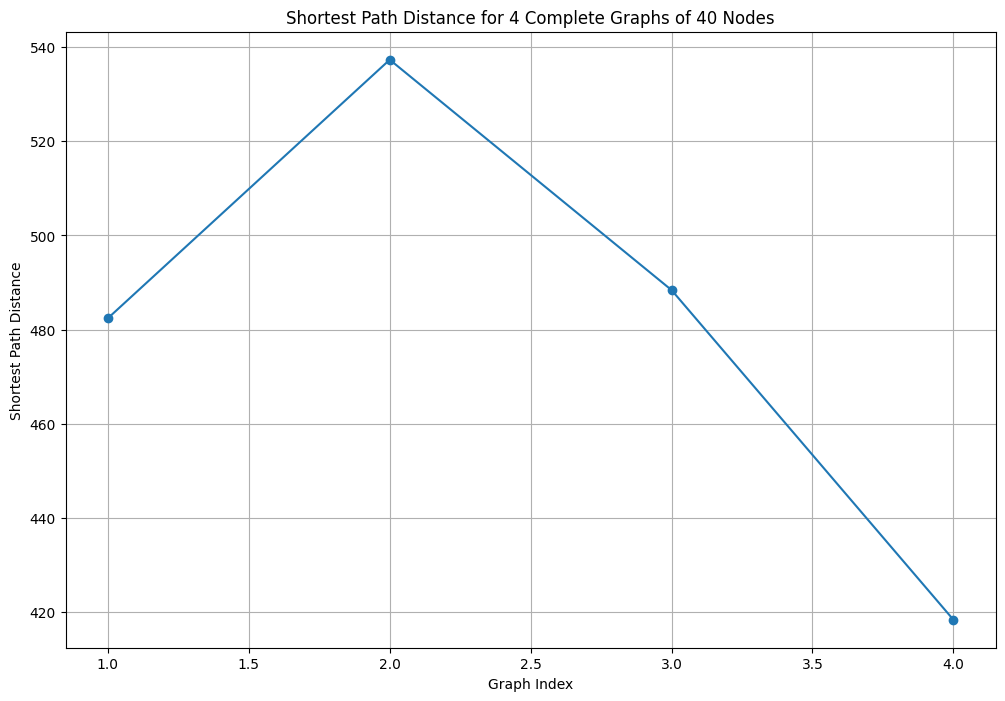

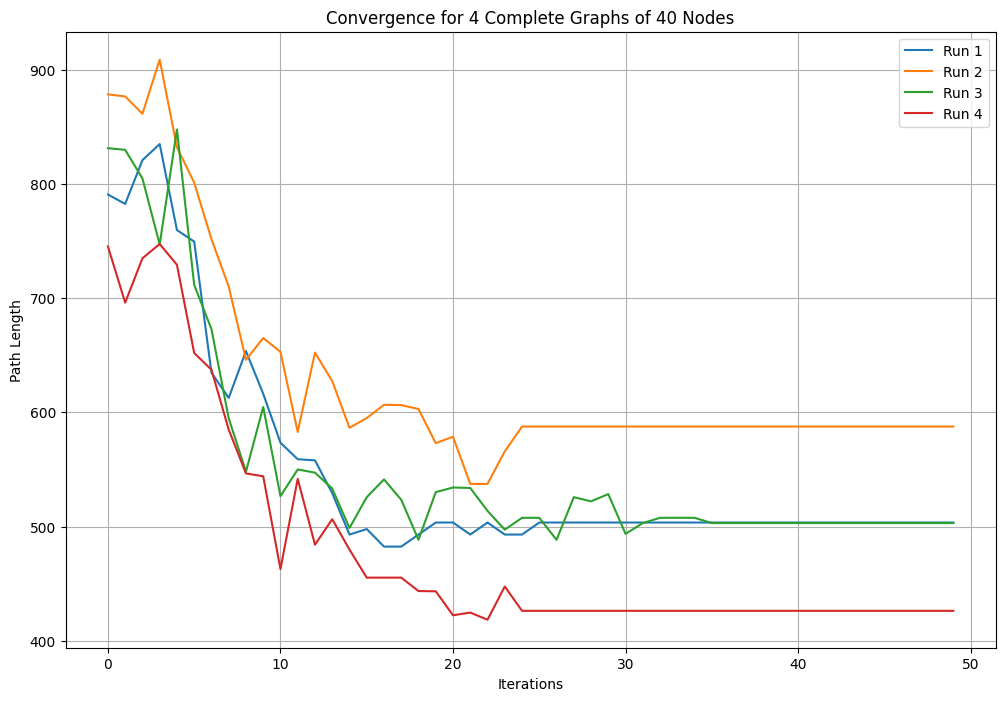

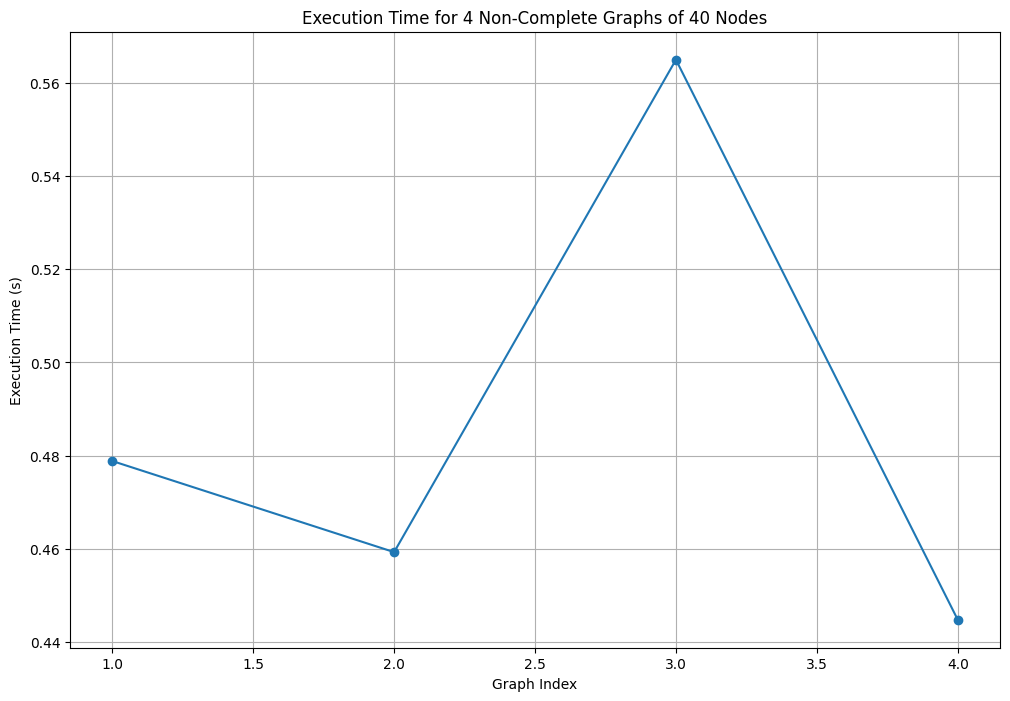

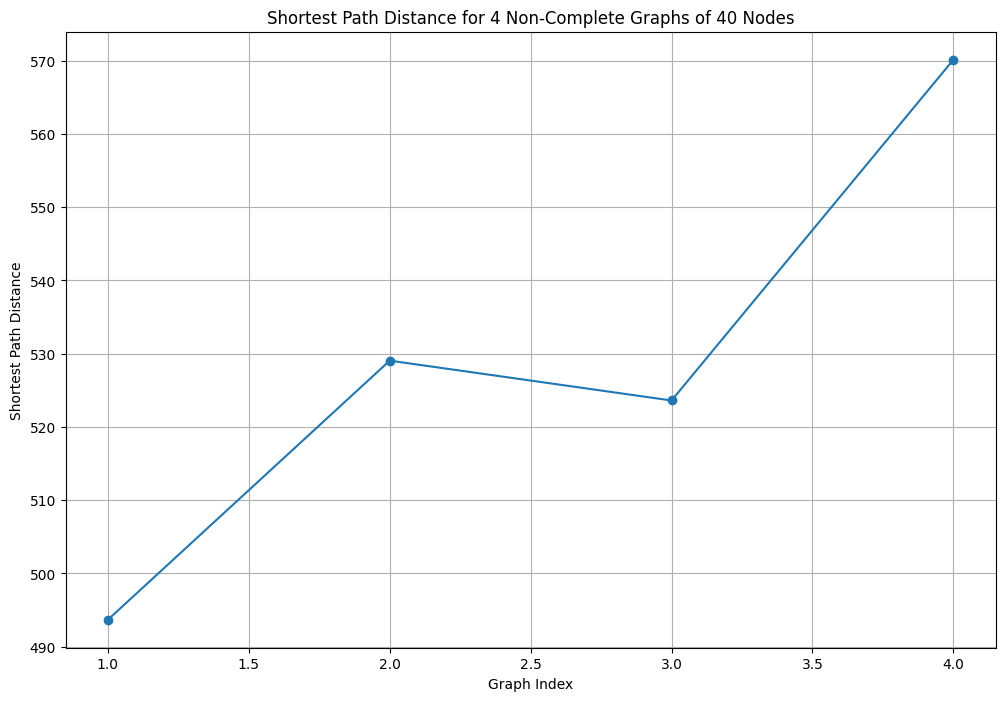

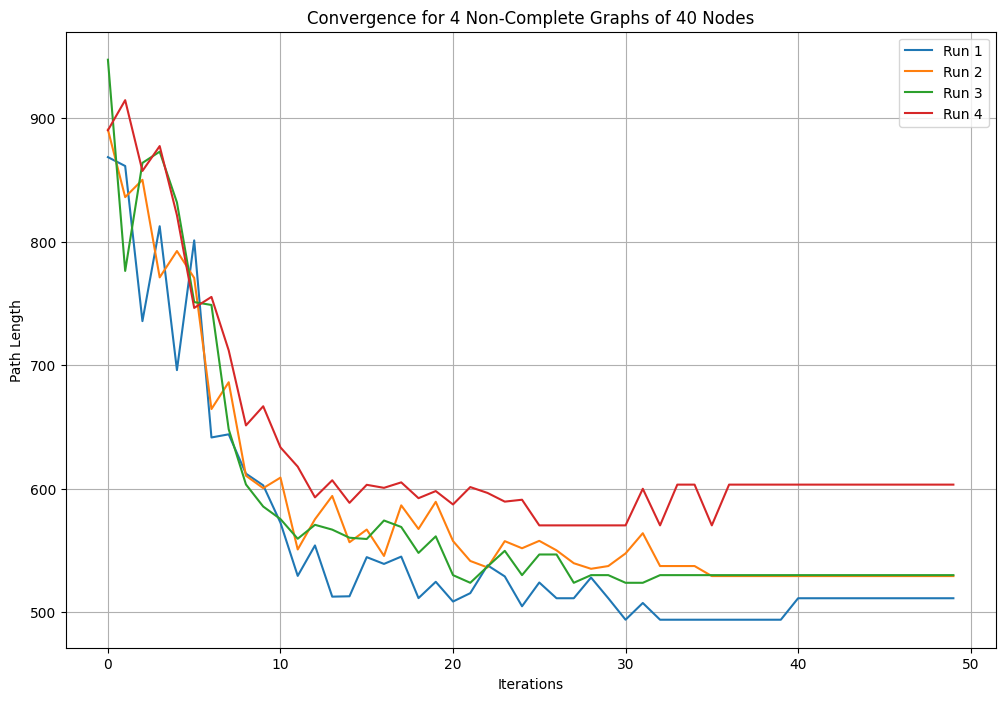

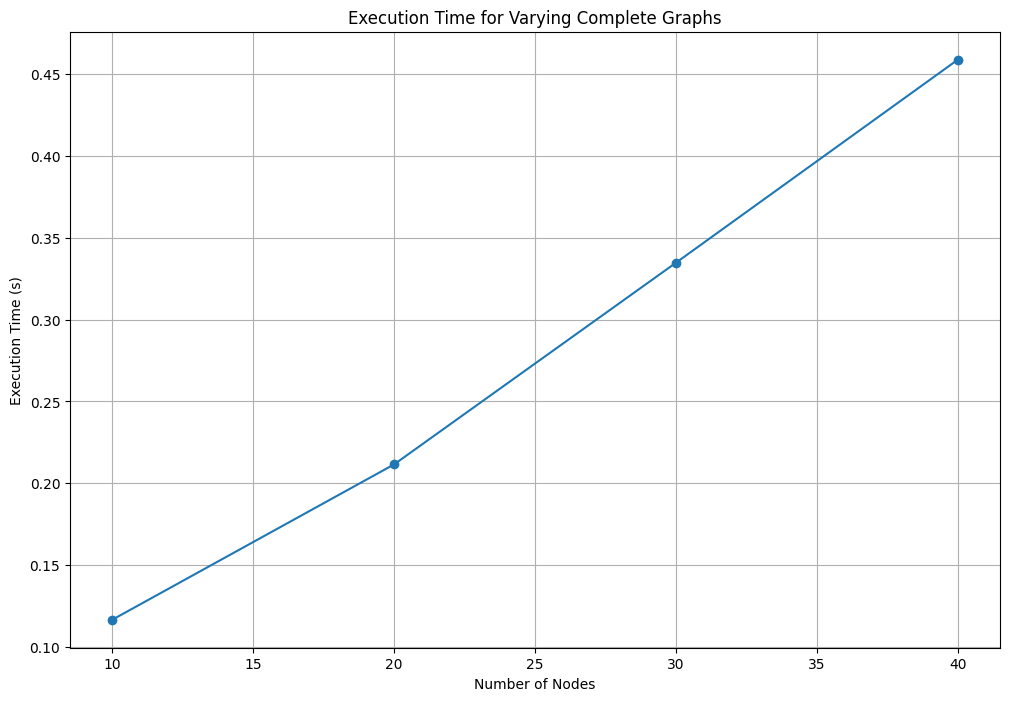

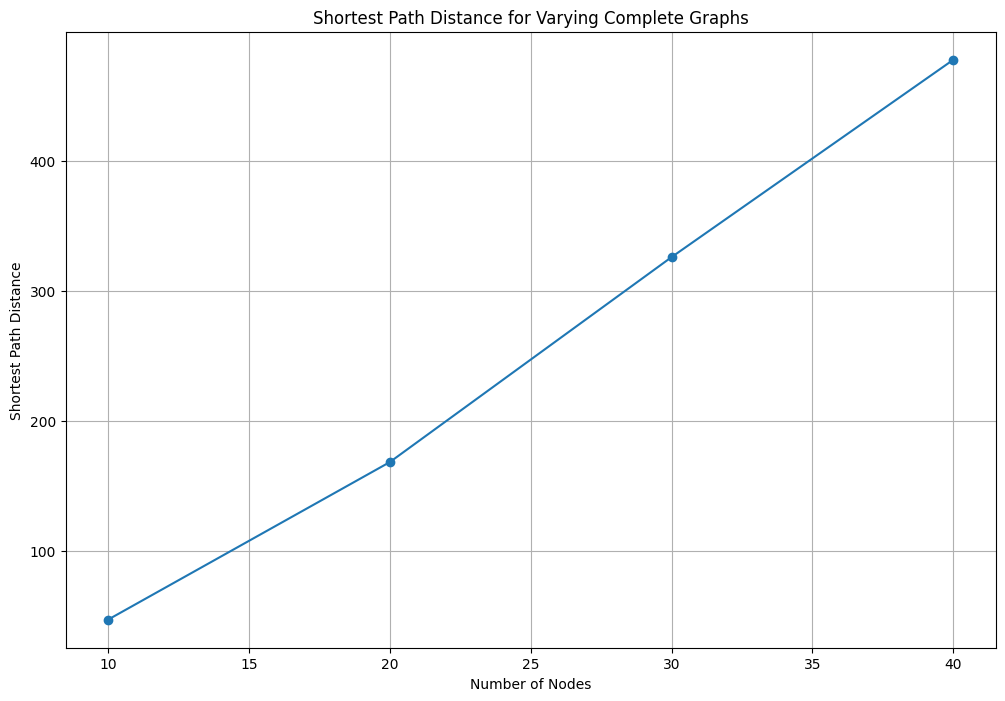

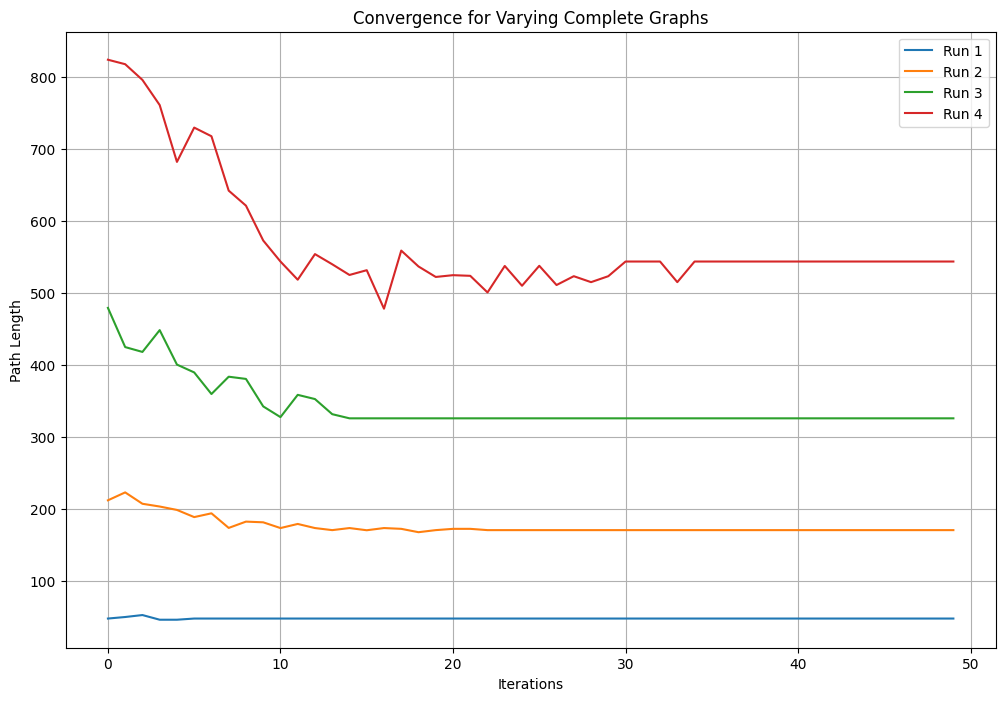

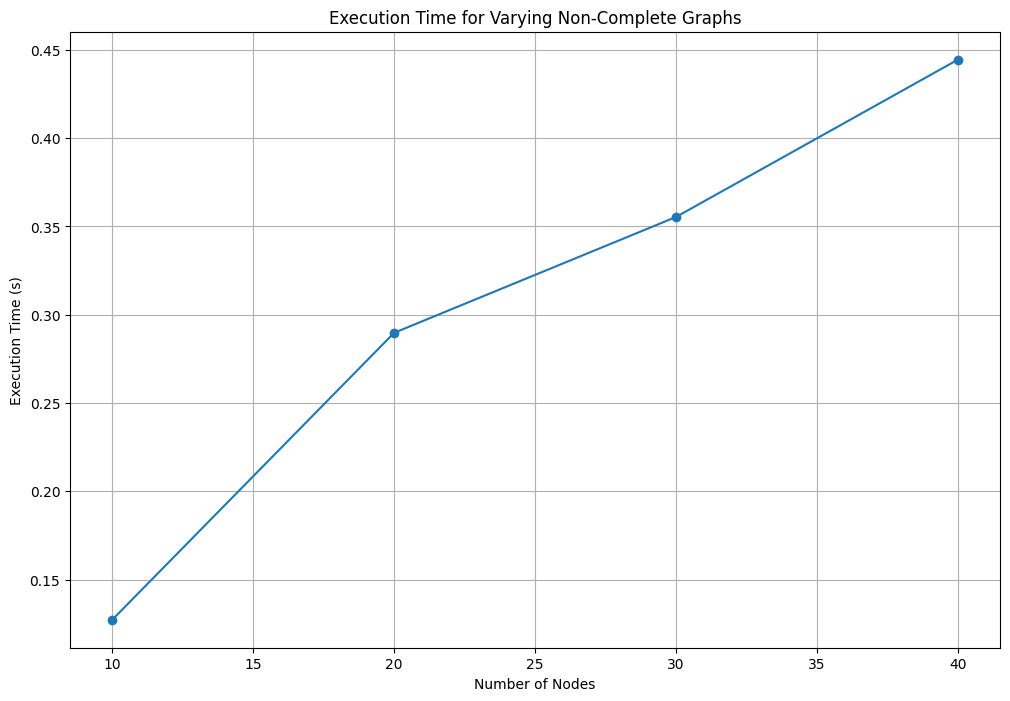

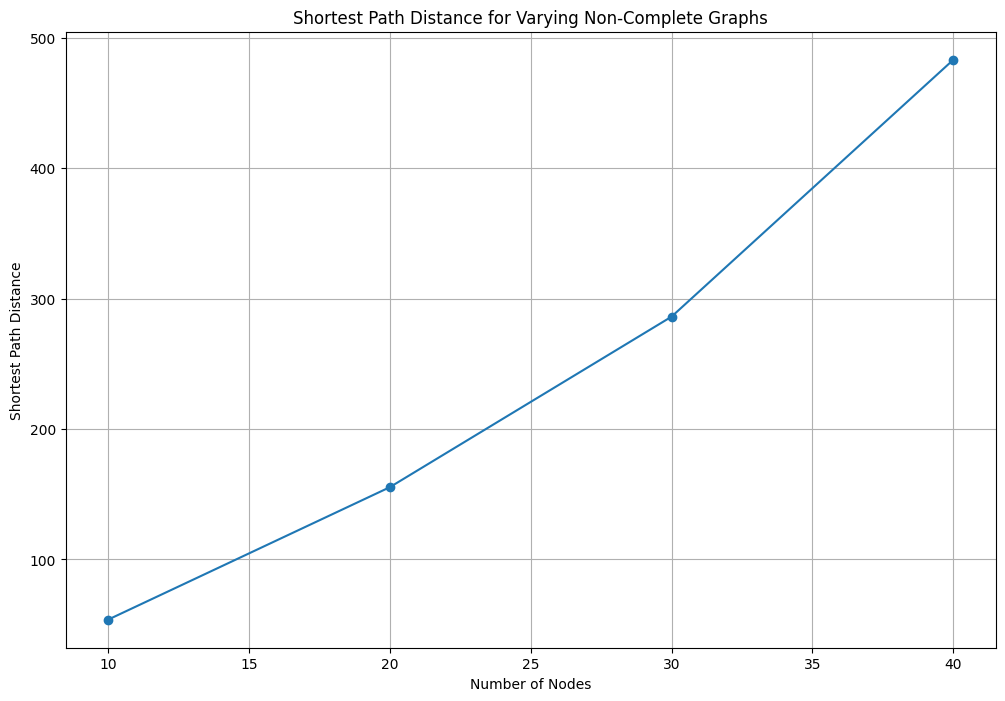

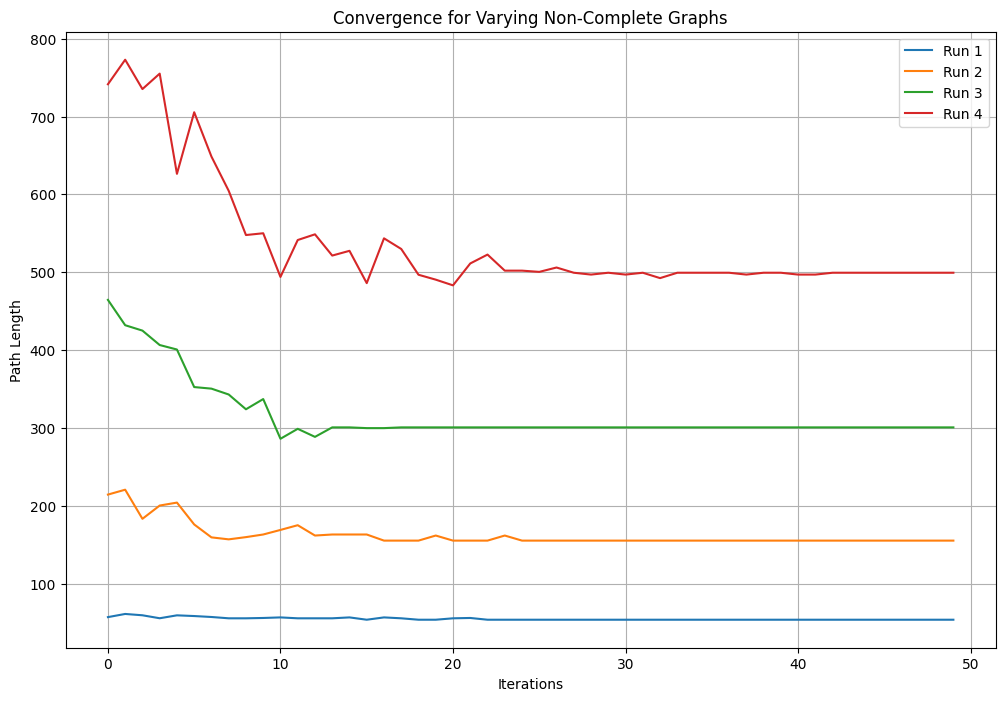

In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import seaborn as sns

# Helper functions for ACO
def gen_path(start, pheromone, distances, alpha, beta):
    path = []
    visited = set()
    visited.add(start)
    prev = start
    for _ in range(len(distances) - 1):
        move = pick_move(pheromone[prev, :], distances[prev, :], visited, alpha, beta)
        path.append((prev, move))
        prev = move
        visited.add(move)
    path.append((prev, start))
    return path

def pick_move(pheromone_row, dist_row, visited, alpha, beta):
    pheromone_row = np.copy(pheromone_row)
    pheromone_row[list(visited)] = 0
    dist_row[dist_row == 0] = np.inf
    with np.errstate(divide='ignore'):
        row = pheromone_row ** alpha * ((1.0 / dist_row) ** beta)
    row = np.nan_to_num(row)
    norm_row = row / row.sum()
    move = np.random.choice(range(len(pheromone_row)), 1, p=norm_row)[0]
    return move

def gen_all_paths(n_ants, pheromone, distances, alpha, beta):
    all_paths = []
    for i in range(n_ants):
        path = gen_path(0, pheromone, distances, alpha, beta)
        all_paths.append((path, calc_path_length(path, distances)))
    return all_paths

def calc_path_length(path, distances):
    total_dist = 0
    for (i, j) in path:
        total_dist += distances[i, j]
    return total_dist

def spread_pheromone(all_paths, pheromone, n_best, decay):
    sorted_paths = sorted(all_paths, key=lambda x: x[1])
    for path, dist in sorted_paths[:n_best]:
        for move in path:
            pheromone[move] += 1.0 / dist
    pheromone *= decay

def create_graph(cities_count, complete=True, threshold=0.5):
    mat = np.random.random((cities_count, cities_count))
    mat = mat + mat.T
    np.fill_diagonal(mat, 0)
    adj_matrix = mat * cities_count
    if not complete:
        adj_matrix[adj_matrix < threshold] = 0  # Appliquer un seuil pour éliminer certaines arêtes
    G = nx.from_numpy_array(adj_matrix)
    if not nx.is_connected(G):
        raise ValueError("Le graphe généré n'est pas connecté. Essayez de régénérer la matrice.")
    return G, adj_matrix

def run_aco_on_graph(G, adj_matrix, n_ants, n_best, n_iterations, decay, alpha, beta):
    pheromone = np.ones(adj_matrix.shape) / len(adj_matrix)
    all_time_shortest_path = ("placeholder", np.inf)
    path_lengths = []
    for i in range(n_iterations):
        all_paths = gen_all_paths(n_ants, pheromone, adj_matrix, alpha, beta)
        spread_pheromone(all_paths, pheromone, n_best, decay)
        shortest_path = min(all_paths, key=lambda x: x[1])
        path_lengths.append(shortest_path[1])
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path
    return all_time_shortest_path[1], path_lengths

def execute_and_measure(cities_count, complete=True, threshold=0.5, runs=4):
    execution_times = []
    path_distances = []
    path_convergences = []
    for i in range(runs):
        G, adj_matrix = create_graph(cities_count, complete=complete, threshold=threshold)
        start_time = time.time()
        distance, path_lengths = run_aco_on_graph(G, adj_matrix, n_ants, n_best, n_iterations, decay, alpha, beta)
        exec_time = time.time() - start_time
        execution_times.append(exec_time)
        path_distances.append(distance)
        path_convergences.append(path_lengths)
    return execution_times, path_distances, path_convergences

def plot_convergence(convergences, title, filename):
    plt.figure(figsize=(12, 8))
    for i, convergence in enumerate(convergences):
        plt.plot(convergence, label=f'Run {i+1}')
    plt.xlabel('Iterations')
    plt.ylabel('Path Length')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_results(x, y, xlabel, ylabel, title, filename, hue=None):
    plt.figure(figsize=(12, 8))
    if hue:
        sns.lineplot(x=x, y=y, hue=hue, marker='o')
    else:
        plt.plot(x, y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Parameters for ACO
n_ants = 10
n_best = 5
n_iterations = 50
decay = 0.5
alpha = 1
beta = 2

# Experiment 1: 4 Complete Graphs of 40 Nodes
cities_count = 40
execution_times_complete_40, path_distances_complete_40, convergences_complete_40 = execute_and_measure(cities_count, complete=True)

# Plot the execution times for complete graphs of 40 nodes
plot_results(range(1, 5), execution_times_complete_40, 'Graph Index', 'Execution Time (s)',
             'Execution Time for 4 Complete Graphs of 40 Nodes', 'execution_times_complete_40_nodes.png')

# Plot the path distances for complete graphs of 40 nodes
plot_results(range(1, 5), path_distances_complete_40, 'Graph Index', 'Shortest Path Distance',
             'Shortest Path Distance for 4 Complete Graphs of 40 Nodes', 'path_distances_complete_40_nodes.png')

# Plot the convergence for complete graphs of 40 nodes
plot_convergence(convergences_complete_40, 'Convergence for 4 Complete Graphs of 40 Nodes', 'convergence_complete_40_nodes.png')

# Experiment 2: 4 Non-Complete Graphs of 40 Nodes
execution_times_non_complete_40, path_distances_non_complete_40, convergences_non_complete_40 = execute_and_measure(cities_count, complete=False, threshold=0.5)

# Plot the execution times for non-complete graphs of 40 nodes
plot_results(range(1, 5), execution_times_non_complete_40, 'Graph Index', 'Execution Time (s)',
             'Execution Time for 4 Non-Complete Graphs of 40 Nodes', 'execution_times_non_complete_40_nodes.png')

# Plot the path distances for non-complete graphs of 40 nodes
plot_results(range(1, 5), path_distances_non_complete_40, 'Graph Index', 'Shortest Path Distance',
             'Shortest Path Distance for 4 Non-Complete Graphs of 40 Nodes', 'path_distances_non_complete_40_nodes.png')

# Plot the convergence for non-complete graphs of 40 nodes
plot_convergence(convergences_non_complete_40, 'Convergence for 4 Non-Complete Graphs of 40 Nodes', 'convergence_non_complete_40_nodes.png')

# Experiment 3: Varying number of nodes for complete graphs
cities_counts = [10, 20, 30, 40]
execution_times_varying_complete = []
path_distances_varying_complete = []
convergences_varying_complete = []

for cities_count in cities_counts:
    exec_times, path_dists, convergences = execute_and_measure(cities_count, complete=True, runs=1)
    execution_times_varying_complete.append(exec_times[0])
    path_distances_varying_complete.append(path_dists[0])
    convergences_varying_complete.append(convergences[0])

# Plot the execution times for varying complete graphs
plot_results(cities_counts, execution_times_varying_complete, 'Number of Nodes', 'Execution Time (s)',
             'Execution Time for Varying Complete Graphs', 'execution_times_varying_complete.png')

# Plot the path distances for varying complete graphs
plot_results(cities_counts, path_distances_varying_complete, 'Number of Nodes', 'Shortest Path Distance',
             'Shortest Path Distance for Varying Complete Graphs', 'path_distances_varying_complete.png')

# Plot the convergence for varying complete graphs
plot_convergence(convergences_varying_complete, 'Convergence for Varying Complete Graphs', 'convergence_varying_complete.png')

# Experiment 4: Varying number of nodes for non-complete graphs
execution_times_varying_non_complete = []
path_distances_varying_non_complete = []
convergences_varying_non_complete = []

for cities_count in cities_counts:
    exec_times, path_dists, convergences = execute_and_measure(cities_count, complete=False, threshold=0.5, runs=1)
    execution_times_varying_non_complete.append(exec_times[0])
    path_distances_varying_non_complete.append(path_dists[0])
    convergences_varying_non_complete.append(convergences[0])

# Plot the execution times for varying non-complete graphs
plot_results(cities_counts, execution_times_varying_non_complete, 'Number of Nodes', 'Execution Time (s)',
             'Execution Time for Varying Non-Complete Graphs', 'execution_times_varying_non_complete.png')

# Plot the path distances for varying non-complete graphs
plot_results(cities_counts, path_distances_varying_non_complete, 'Number of Nodes', 'Shortest Path Distance',
             'Shortest Path Distance for Varying Non-Complete Graphs', 'path_distances_varying_non_complete.png')

# Plot the convergence for varying non-complete graphs
plot_convergence(convergences_varying_non_complete, 'Convergence for Varying Non-Complete Graphs', 'convergence_varying_non_complete.png')

# Save the execution times and path distances
np.savetxt('execution_times_complete_40_nodes.csv', execution_times_complete_40, delimiter=',')
np.savetxt('path_distances_complete_40_nodes.csv', path_distances_complete_40, delimiter=',')
np.savetxt('execution_times_non_complete_40_nodes.csv', execution_times_non_complete_40, delimiter=',')
np.savetxt('path_distances_non_complete_40_nodes.csv', path_distances_non_complete_40, delimiter=',')
np.savetxt('execution_times_varying_complete.csv', execution_times_varying_complete, delimiter=',')
np.savetxt('path_distances_varying_complete.csv', path_distances_varying_complete, delimiter=',')
np.savetxt('execution_times_varying_non_complete.csv', execution_times_varying_non_complete, delimiter=',')
np.savetxt('path_distances_varying_non_complete.csv', path_distances_varying_non_complete, delimiter=',')
